# Entrenamiento

## Carga de los datos

Primero de todo cargamos los datos a los que le hicimos la limpieza

In [1]:
from datasets import load_from_disk

path = "data/opus100_croped"
# path = "data/opus100_croped_10" # ! Quitar
opus100_croped = load_from_disk(path)

Volvemos a hacer una inspección rápida de los datos

In [2]:
print(f"dataset keys: {opus100_croped.keys()}")

dataset keys: dict_keys(['test', 'train', 'validation'])


In [3]:
print(f"train length: {len(opus100_croped['train'])},\nvalidation length: {len(opus100_croped['validation'])},\ntest length: {len(opus100_croped['test'])}")

train length: 463854,
validation length: 681,
test length: 691


In [4]:
print(f"train keys: {opus100_croped['train'][0].keys()},\nvalidation keys: {opus100_croped['validation'][0].keys()},\ntest keys: {opus100_croped['test'][0].keys()}")

train keys: dict_keys(['translation']),
validation keys: dict_keys(['translation']),
test keys: dict_keys(['translation'])


In [5]:
print(f"train translation keys: {opus100_croped['train'][0]['translation'].keys()},\nvalidation translation keys: {opus100_croped['validation'][0]['translation'].keys()},\ntest translation keys: {opus100_croped['test'][0]['translation'].keys()}")

train translation keys: dict_keys(['en', 'es']),
validation translation keys: dict_keys(['en', 'es']),
test translation keys: dict_keys(['en', 'es'])


In [6]:
import numpy.random as random
idx = random.randint(0, len(opus100_croped["train"]))
opus100_croped["train"][idx]["translation"]

{'en': 'One of us is gonna win that paid vacation.',
 'es': 'Uno de nosotros tendrá vacaciones pagas.'}

## Dataset y dataloader

Ahora que hemos visto cómo es el dataset que nos hemos descargado, vamos a crear un dataset y un dataloader de python

Primero creamos la clase `Opus100Dataset`

In [7]:
import torch
from torch.utils.data import Dataset

class Opus100Dataset(Dataset):
    def __init__(self, dataset, source_language, target_language, tokenizer, start_token, end_token, padding_token, max_length):
        self.dataset = dataset
        self.source_language = source_language
        self.target_language = target_language
        self.tokenizer = tokenizer
        self.start_token = start_token
        self.end_token = end_token
        self.padding_token = padding_token
        self.max_length = max_length
    
    def __len__(self):
        return len(self.dataset)
    
    def encode(self, text):
        encoded = self.tokenizer(text)
        encoded = self.start_token + encoded + self.end_token
        if len(encoded) > self.max_length:  # Truncate if too long
            encoded = encoded[:self.max_length]
        else:  # Pad if too short
            encoded = encoded + self.padding_token * (self.max_length - len(encoded))
        return torch.tensor(encoded)
    
    def decode(self, tensor, decoder):
        end_token_position = (tensor == self.end_token[0]).nonzero(as_tuple=True)[0]
        encoded_sentence = tensor[1:end_token_position].tolist()
        return decoder(encoded_sentence)
    
    def __getitem__(self, idx):
        source = self.dataset[idx]["translation"][self.source_language]
        source = self.encode(source)

        target = self.dataset[idx]["translation"][self.target_language]
        target = self.encode(target)
        return source, target


Ahora creamos un objeto para `train`, `validation` y `test`

In [8]:
import tiktoken

encoder = tiktoken.get_encoding("cl100k_base")

start_token = chr(1)
start_token = encoder.encode(start_token)

end_token = chr(2)
end_token = encoder.encode(end_token)

padding_token = chr(3)
padding_token = encoder.encode(padding_token)

max_secuence_length = 104 + 2 #128
# max_secuence_length = 10 + 2 # ! Quitar

train_dataset = Opus100Dataset(opus100_croped["train"], "en", "es", encoder.encode, start_token, end_token, padding_token, max_secuence_length)
validation_dataset = Opus100Dataset(opus100_croped["validation"], "en", "es", encoder.encode, start_token, end_token, padding_token, max_secuence_length)
test_dataset = Opus100Dataset(opus100_croped["test"], "en", "es", encoder.encode, start_token, end_token, padding_token, max_secuence_length)


Vamos a ver si las longitudes coinciden

In [9]:
print(f"len opus100 train {len(opus100_croped['train'])}, len train_dataset {len(train_dataset)}")
print(f"len opus100 validation {len(opus100_croped['validation'])}, len validation_dataset {len(validation_dataset)}")
print(f"len opus100 test {len(opus100_croped['test'])}, len test_dataset {len(test_dataset)}")

len opus100 train 463854, len train_dataset 463854
len opus100 validation 681, len validation_dataset 681
len opus100 test 691, len test_dataset 691


Veamos ahora si una muestra de entrenamiento coincide

In [10]:
idx = 259178 #random.randint(0, len(train_dataset))

opus100_idx_en = opus100_croped["train"][idx]["translation"]["en"]
opus100_idx_es = opus100_croped["train"][idx]["translation"]["es"]
print(f"opus100_idx_en: {opus100_idx_en}, opus100_idx_es: {opus100_idx_es}")

sample_train_dataset_idx_en, sample_train_dataset_idx_es = train_dataset[idx]
sample_train_dataset_idx_en_sentence = train_dataset.decode(sample_train_dataset_idx_en, encoder.decode)
sample_train_dataset_idx_es_sentence = train_dataset.decode(sample_train_dataset_idx_es, encoder.decode)
print(f"sample train_dataset en: {sample_train_dataset_idx_en_sentence}, sample train_dataset es: {sample_train_dataset_idx_es_sentence}")

opus100_idx_en: Elaine, are you gaining weight?, opus100_idx_es: Elaine, ¿Estás engordando?
sample train_dataset en: Elaine, are you gaining weight?, sample train_dataset es: Elaine, ¿Estás engordando?


Vamos a ver si tiene la longitud que debería tener

In [11]:
sample_train_dataset_idx_en.shape

torch.Size([12])

Vamos ahora a ver muestras de validación y test

In [12]:
idx = 114 #random.randint(0, len(validation_dataset))

opus100_idx_en = opus100_croped["validation"][idx]["translation"]["en"]
opus100_idx_es = opus100_croped["validation"][idx]["translation"]["es"]
print(f"opus100_idx_en: {opus100_idx_en}, opus100_idx_es: {opus100_idx_es}")

sample_validation_dataset_idx_en, sample_validation_dataset_idx_es = validation_dataset[idx]
sample_validation_dataset_idx_en_sentence = validation_dataset.decode(sample_validation_dataset_idx_en, encoder.decode)
sample_validation_dataset_idx_es_sentence = validation_dataset.decode(sample_validation_dataset_idx_es, encoder.decode)
print(f"sample validation_dataset en: {sample_validation_dataset_idx_en_sentence}, sample validation_dataset es: {sample_validation_dataset_idx_es_sentence}")

opus100_idx_en: The guy's been really good to us., opus100_idx_es: Fue muy bueno con nosotros.
sample validation_dataset en: The guy's been really good to us., sample validation_dataset es: Fue muy bueno con nosotros.


In [13]:
idx = 510 #random.randint(0, len(test_dataset))

opus100_idx_en = opus100_croped["test"][idx]["translation"]["en"]
opus100_idx_es = opus100_croped["test"][idx]["translation"]["es"]
print(f"opus100_idx_en: {opus100_idx_en}, opus100_idx_es: {opus100_idx_es}")

sample_test_dataset_idx_en, sample_test_dataset_idx_es = test_dataset[idx]
sample_test_dataset_idx_en_sentence = test_dataset.decode(sample_test_dataset_idx_en, encoder.decode)
sample_test_dataset_idx_es_sentence = test_dataset.decode(sample_test_dataset_idx_es, encoder.decode)
print(f"sample test_dataset en: {sample_test_dataset_idx_en_sentence}, sample test_dataset es: {sample_test_dataset_idx_es_sentence}")

opus100_idx_en: What fits here?, opus100_idx_es: ¿Qué encaja aquí?
sample test_dataset en: What fits here?, sample test_dataset es: ¿Qué encaja aquí?


Vemos que el dataset está bien creado, ahora creamos el `Dataloader`

In [14]:
# import numpy as np
# # ! Quitar
# def subsample_dataset(dataset, new_size):
#     indices = np.random.choice(len(dataset), new_size, replace=False)
#     indices = indices.tolist()  # Convert numpy.int64 indices to native int
#     return torch.utils.data.Subset(dataset, indices)

# new_size = 500  # Elige el tamaño que prefieras

# train_dataset = subsample_dataset(train_dataset, new_size)
# validation_dataset = subsample_dataset(validation_dataset, new_size)
# test_dataset = subsample_dataset(test_dataset, new_size)

In [15]:
from torch.utils.data import DataLoader

BS = 16
# BS = 128 # ! Quitar

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BS, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False)


Vamos a ver una muestra

In [16]:
batch_en, batch_es = next(iter(train_dataloader))
print(f"batch_en shape: {batch_en.shape}, batch_es shape: {batch_es.shape}")

batch_en shape: torch.Size([128, 12]), batch_es shape: torch.Size([128, 12])


## Modelo

Volvemos a escribir todo el código del transformer y creamos un objeto de este

### Clases de bajo nivel

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_model_dim):
        super().__init__()
        self.embedding_dim = embedding_model_dim
        positional_encoding = torch.zeros(max_sequence_len, self.embedding_dim)
        for pos in range(max_sequence_len):
            for i in range(0, self.embedding_dim, 2):
                positional_encoding[pos, i]     = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / self.embedding_dim))))
                positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i+1)) / self.embedding_dim))))
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        x = x * torch.sqrt(torch.tensor(self.embedding_dim))
        sequence_len = x.size(1)
        x = x + self.positional_encoding[:,:sequence_len]
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, query, key, value, mask=None):
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float('-inf'))
        attention_matrix = torch.softmax(scale, dim=-1)
        output = torch.matmul(attention_matrix, value)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, dim_embedding):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.dim_proyection = dim_embedding // heads
        self.heads = heads
        self.proyection_Q = nn.Linear(dim_embedding, dim_embedding)
        self.proyection_K = nn.Linear(dim_embedding, dim_embedding)
        self.proyection_V = nn.Linear(dim_embedding, dim_embedding)
        self.attention = nn.Linear(dim_embedding, dim_embedding)
        self.scaled_dot_product_attention = ScaledDotProductAttention(self.dim_proyection)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        proyection_Q = self.proyection_Q(Q).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_K = self.proyection_K(K).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_V = self.proyection_V(V).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_Q = proyection_Q.transpose(1,2)
        proyection_K = proyection_K.transpose(1,2)
        proyection_V = proyection_V.transpose(1,2)
        scaled_dot_product_attention = self.scaled_dot_product_attention(proyection_Q, proyection_K, proyection_V, mask=mask)
        concat = scaled_dot_product_attention.transpose(1,2).contiguous().view(batch_size, -1, self.dim_embedding)
        output = self.attention(concat)
        return output

class AddAndNorm(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.normalization = nn.LayerNorm(dim_embedding)

    def forward(self, x, sublayer):
        return self.normalization(torch.add(x, sublayer))

class FeedForward(nn.Module):
    def __init__(self, dim_embedding, increment=4):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim_embedding, dim_embedding*increment),
            nn.ReLU(),
            nn.Linear(dim_embedding*increment, dim_embedding)
        )
    
    def forward(self, x):
        x = self.feed_forward(x)
        return x

class Linear(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dim_embedding, vocab_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.softmax(x)
        return x

class Dropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return torch.nn.functional.dropout(x, p=self.p)
        else:
            return x


### Clases de medio nivel

In [18]:
class EncoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
    
    def forward(self, x):
        multi_head_attention = self.multi_head_attention(x, x, x)
        dropout1 = self.dropout_1(multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(x, dropout1)
        feed_forward = self.feed_forward(add_and_norm_1)
        dropout2 = self.dropout_2(feed_forward)
        add_and_norm_2 = self.add_and_norm_2(add_and_norm_1, dropout2)
        return add_and_norm_2

class Encoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.input_embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
    
    def forward(self, x):
        input_embedding = self.input_embedding(x)
        positional_encoding = self.positional_encoding(input_embedding)
        encoder = self.encoder(positional_encoding)
        return encoder

class DecoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.encoder_decoder_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_3 = Dropout(prob_dropout)
        self.add_and_norm_3 = AddAndNorm(dim_embedding)
    
    def forward(self, x, encoder_output, mask=None):
        Q = x
        K = x
        V = x
        masked_multi_head_attention = self.masked_multi_head_attention(Q, K, V, mask=mask)
        dropout1 = self.dropout_1(masked_multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(dropout1, x)

        Q = add_and_norm_1
        K = encoder_output
        V = encoder_output
        encoder_decoder_multi_head_attention = self.encoder_decoder_multi_head_attention(Q, K, V)
        dropout2 = self.dropout_2(encoder_decoder_multi_head_attention)
        add_and_norm_2 = self.add_and_norm_2(dropout2, add_and_norm_1)

        feed_forward = self.feed_forward(add_and_norm_2)
        dropout3 = self.dropout_3(feed_forward)
        add_and_norm_3 = self.add_and_norm_3(dropout3, add_and_norm_2)

        return add_and_norm_3

class Decoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x, encoder_output, mask=None):
        for decoder_layer in self.layers:
            x = decoder_layer(x, encoder_output, mask)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout=0.1):
        super().__init__()
        self.embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.linear = Linear(dim_embedding, vocab_size)
        self.softmax = Softmax()
    
    def forward(self, x, encoder_output, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.decoder(x, encoder_output, mask)
        x = self.linear(x)
        x = self.softmax(x)
        return x


### Clase de alto nivel

In [19]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout)
        self.decoder = TransformerDecoder(heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout)
    
    def forward(self, source, target, mask=None):
        encoder_output = self.encoder(source)
        decoder_output = self.decoder(target, encoder_output, mask)
        return decoder_output


### Transformer

In [20]:
def create_mask(sequence_len):
    """
    Args:
        sequence_len: length of sequence
        
    Returns:
        mask matrix
    """
    mask = torch.tril(torch.ones((sequence_len, sequence_len)))
    return mask


In [21]:
vocab_size = encoder.n_vocab
dim_embedding = 512
max_sequence_len = 104
heads = 8
Nx = 6
prob_dropout = 0.1
print(f"vocab_size: {vocab_size}, dim_embedding: {dim_embedding}, max_secuence_length: {max_secuence_length}, heads: {heads}, Nx: {Nx}, prob_dropout: {prob_dropout}")

transformer = Transformer(vocab_size=vocab_size,
                          dim_embedding=dim_embedding,
                          max_sequence_len=max_secuence_length,
                          heads=heads,
                          Nx=Nx,
                          prob_dropout=prob_dropout)

mask = create_mask(max_secuence_length)

vocab_size: 100277, dim_embedding: 512, max_secuence_length: 12, heads: 8, Nx: 6, prob_dropout: 0.1


Vamos a probar el modelo con una muestra del dataloader

In [22]:
idx = 259178 #
idx = random.randint(0, len(train_dataset))
print(f"idx: {idx}")

sample_train_dataset_idx_en, sample_train_dataset_idx_es = train_dataset[idx]
sample_train_dataset_idx_en_sentence = train_dataset.decode(sample_train_dataset_idx_en, encoder.decode)
sample_train_dataset_idx_es_sentence = train_dataset.decode(sample_train_dataset_idx_es, encoder.decode)
print(f"sample sentence train_dataset en: {sample_train_dataset_idx_en_sentence}")
print(f"sample sentence train_dataset es: {sample_train_dataset_idx_es_sentence}")
print("")
print(f"sample train_dataset en: {sample_train_dataset_idx_en}, shape: {sample_train_dataset_idx_en.shape}")
print(f"sample train_dataset es: {sample_train_dataset_idx_es}, shape: {sample_train_dataset_idx_es.shape}")

idx: 278


AttributeError: 'Subset' object has no attribute 'decode'

In [23]:
source = sample_train_dataset_idx_en.unsqueeze(0)
target = sample_train_dataset_idx_es.unsqueeze(0)
output = transformer(source, target, mask)
output.shape

torch.Size([1, 12, 100277])

In [24]:
batch_en, batch_es = next(iter(train_dataloader))
print(f"batch_en shape: {batch_en.shape}, batch_es shape: {batch_es.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_en = batch_en.to(device)
batch_es = batch_es.to(device)
mask = mask.to(device)
transformer = transformer.to(device)

output = transformer(batch_en, batch_es, mask)
output.shape

batch_en shape: torch.Size([128, 12]), batch_es shape: torch.Size([128, 12])


torch.Size([128, 12, 100277])

## Entrenamiento

### Función de pérdida

Usamos la clase creada para el label smoothing

In [25]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.dim = dim
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            mask = (target == self.ignore_index).unsqueeze(1).expand_as(true_dist)
            if mask.any():
                true_dist[mask] = 0
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

loss_function = LabelSmoothingLoss(classes=vocab_size, smoothing=0.1, ignore_index=padding_token[0])


### Optimizador

Creamos el optimizador con los parámetros del paper e implementamos el scheduler del learning rate

In [26]:
LR = 1e-4
optimizer = torch.optim.Adam(transformer.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

In [27]:
def calculate_lr(step_num, dim_embeding_model=512, warmup_steps=4000):
    step_num += 1e-7 # Avoid division by zero
    return (dim_embeding_model**-0.5) * min(step_num**-0.5, step_num*(warmup_steps**-1.5))

lr_lambda = lambda step: calculate_lr(step, dim_embeding_model=dim_embedding)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Ciclo de entrenamiento

In [45]:
import numpy as np

def train_loop(dataloader, model, loss_fn, optimizer, device, mask):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    mean_loss = 0
    lr_list = []
    for batch, (src, trg) in enumerate(dataloader):
        src = src.to(device)
        trg = trg.to(device)
        mask = mask.to(device)

        pred = model(src, trg, mask)
        loss = loss_fn(pred.transpose(1, 2), trg)
        mean_loss += loss.item()

        lr = optimizer.param_groups[0]['lr']
        lr_list.append(lr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(src)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return mean_loss/num_batches, np.array(lr_list)

def validation_loop(dataloader, model, loss_fn, device, mask):
    num_batches = len(dataloader)
    validation_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)
            mask = mask.to(device)

            pred = model(src, trg, mask)
            validation_loss += loss_fn(pred.transpose(1, 2), trg).item()
    validation_loss /= num_batches
    print(f"Avg validation loss: {validation_loss:>8f} \n")
    return validation_loss

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

transformer = transformer.to(device)

device: cuda


In [54]:
epochs = 100000
# epochs = 100 # ! Quitar
train_loss_list = []
train_lr_list = []
test_loss_list = []
train_loss_list = np.array(train_loss_list)
train_lr_list = np.array(train_lr_list)
test_loss_list = np.array(test_loss_list)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_lr = train_loop(train_dataloader, transformer, loss_function, optimizer, device, mask)
    validation_loss = validation_loop(validation_dataloader, transformer, loss_function, device, mask)
    train_loss_list = np.append(train_loss_list, train_loss)
    train_lr_list = np.append(train_lr_list, train_lr)
    test_loss_list = np.append(test_loss_list, validation_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.000209  [    0/  500]
Avg validation loss: 0.000235 

Epoch 2
-------------------------------
loss: 0.000200  [    0/  500]
Avg validation loss: 0.000235 

Epoch 3
-------------------------------
loss: 0.000213  [    0/  500]
Avg validation loss: 0.000235 

Epoch 4
-------------------------------
loss: 0.000212  [    0/  500]
Avg validation loss: 0.000235 

Epoch 5
-------------------------------
loss: 0.000206  [    0/  500]
Avg validation loss: 0.000235 

Epoch 6
-------------------------------
loss: 0.000213  [    0/  500]
Avg validation loss: 0.000235 

Epoch 7
-------------------------------
loss: 0.000210  [    0/  500]
Avg validation loss: 0.000235 

Epoch 8
-------------------------------
loss: 0.000216  [    0/  500]
Avg validation loss: 0.000235 

Epoch 9
-------------------------------
loss: 0.000221  [    0/  500]
Avg validation loss: 0.000235 

Epoch 10
-------------------------------
loss: 0.000208  [    0/  500]
Avg validat

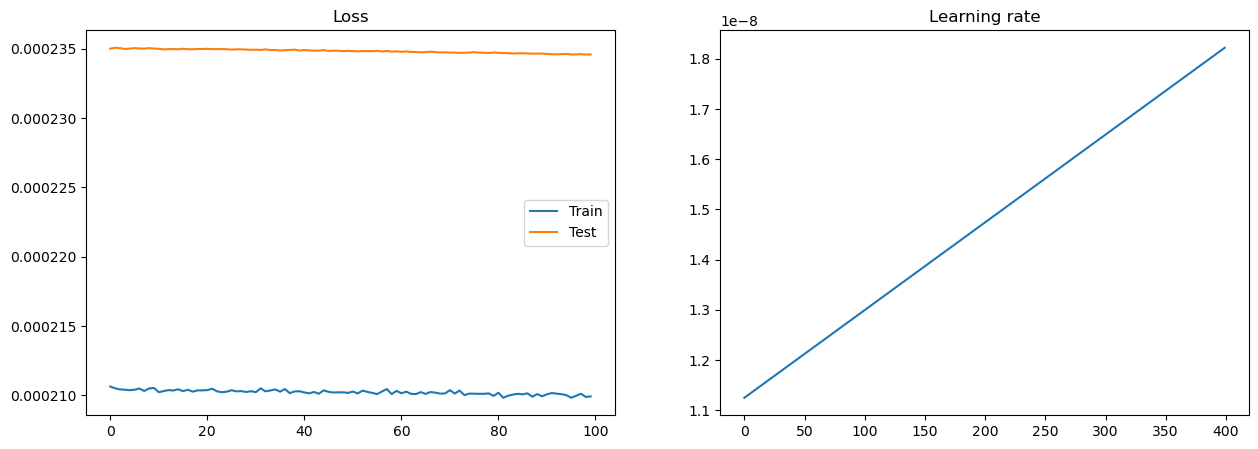

In [57]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_list)
axs[0].plot(test_loss_list)
axs[0].set_title("Loss")
axs[0].legend(["Train", "Test"])
axs[1].plot(train_lr_list)
axs[1].set_title("Learning rate")
plt.show()